In [1]:
import os, sys
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [51]:

def build_gan(data_shape, noise_dim):
    w = data_shape[1] 
    h = data_shape[2]
    d = data_shape[3]
    
    generator = models.Sequential([
        layers.Dense(int(w/4) * int(h/4) * 128, input_shape=[noise_dim]),
        layers.Reshape([int(w/4), int(h/4), 128]),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                     activation="selu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(d, kernel_size=5, strides=2, padding="SAME",
                                     activation="tanh"),
    ])
    discriminator = models.Sequential([
        layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                            activation=layers.LeakyReLU(0.2),
                            input_shape=[w, h, d]),
        layers.Dropout(0.4),
        layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                            activation=layers.LeakyReLU(0.2)),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    
    gan = models.Sequential([generator, discriminator])
    
    return gan

In [52]:
def plot_generated_images(generator, seed):
    generated_images = generator.predict(seed)
    print(generated_images.shape, generated_images[0][0])
    plot_multiple_images(generated_images, 4) 

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
        
    #print(images.shape, images[0][0])
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
    plt.show()

def get_dataset(x_data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(1000)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
    print(dataset)
    return dataset

def make_constants(noise_dim, batch_size):
    y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
    y2 = tf.constant([[1.]] * batch_size)
    seed = tf.random.normal(shape=[16, noise_dim])
    return y1, y2, seed


class GAN():
    def __init__(self, x_data, noise_dim=100, batch_size=32):
    
        self.x_data = x_data
        self.noise_dim = noise_dim
        self.batch_size= batch_size

        self.gan = build_gan(x_data.shape, noise_dim)
        self.generator, self.discriminator = self.gan.layers
        self.gan.summary()

        # When compile generator(gan), discriminator must not trainable!
        self.discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
        self.discriminator.trainable = False
        self.gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

    
    def fit(self, n_epochs):

        # Set data
        dataset = get_dataset(self.x_data, self.batch_size)

        # y1 : half '0' half '1' for discriminator train 
        # y2 : all '1' for generator train
        y1, y2, seed = make_constants(self.noise_dim, self.batch_size)
        #plot_generated_images(self.generator, seed)

        # Train
        for epoch in range(n_epochs):
            print("Epoch {}/{}".format(epoch + 1, n_epochs))
            for images in dataset:
                # phase 1 - training the discriminator
                noise = tf.random.normal(shape=[self.batch_size, self.noise_dim])
                generated_images = self.generator.predict(noise)

                self.discriminator.trainable = True
                self.discriminator.train_on_batch(tf.concat([generated_images, images], axis=0), y1)

                # phase 2 - training the generator
                noise = tf.random.normal(shape=[self.batch_size, self.noise_dim])
                self.discriminator.trainable = False
                self.gan.train_on_batch(noise, y2)

            #plot_generated_images(self.generator, seed)


In [30]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train.shape)
x_train = x_train.astype(np.float32) / 255
print(x_train.shape)
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train* 2. - 1. 

(60000, 28, 28)
(60000, 28, 28)


(50000, 32, 32, 3) [[0.49019608 0.49019608 0.45490196]
 [0.43137255 0.39607844 0.35686275]
 [0.4        0.3529412  0.3254902 ]
 [0.41568628 0.38039216 0.36862746]
 [0.41568628 0.3882353  0.3764706 ]
 [0.5529412  0.5294118  0.5137255 ]
 [0.6862745  0.6666667  0.6509804 ]
 [0.6862745  0.6627451  0.64705884]
 [0.5803922  0.5529412  0.53333336]
 [0.41568628 0.34509805 0.3254902 ]
 [0.2901961  0.21176471 0.19215687]
 [0.2784314  0.21960784 0.19215687]
 [0.28627452 0.23921569 0.20784314]
 [0.3137255  0.27450982 0.24705882]
 [0.3764706  0.3254902  0.3019608 ]
 [0.43137255 0.38431373 0.36078432]
 [0.4862745  0.44313726 0.41960785]
 [0.5529412  0.5137255  0.4862745 ]
 [0.6117647  0.57254905 0.5568628 ]
 [0.6509804  0.61960787 0.62352943]
 [0.7019608  0.67058825 0.68235296]
 [0.7372549  0.7176471  0.72156864]
 [0.76862746 0.75686276 0.7607843 ]
 [0.8        0.7921569  0.8039216 ]
 [0.8117647  0.8156863  0.8392157 ]
 [0.8039216  0.8156863  0.84313726]
 [0.79607844 0.8156863  0.84313726]
 [0.79215

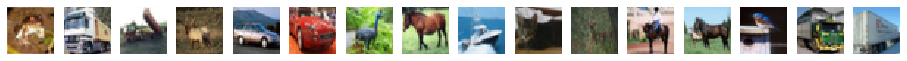

(50000, 32, 32, 3) [[-0.01960784 -0.01960784 -0.09019607]
 [-0.1372549  -0.20784312 -0.2862745 ]
 [-0.19999999 -0.29411763 -0.3490196 ]
 [-0.16862744 -0.23921567 -0.26274508]
 [-0.16862744 -0.2235294  -0.24705881]
 [ 0.10588241  0.05882359  0.02745104]
 [ 0.37254906  0.33333337  0.30196083]
 [ 0.37254906  0.32549024  0.2941177 ]
 [ 0.16078436  0.10588241  0.06666672]
 [-0.16862744 -0.3098039  -0.3490196 ]
 [-0.41960782 -0.5764706  -0.6156863 ]
 [-0.44313723 -0.56078434 -0.6156863 ]
 [-0.42745095 -0.52156866 -0.58431375]
 [-0.372549   -0.45098037 -0.5058824 ]
 [-0.24705881 -0.3490196  -0.3960784 ]
 [-0.1372549  -0.23137254 -0.27843136]
 [-0.02745098 -0.11372548 -0.1607843 ]
 [ 0.10588241  0.02745104 -0.02745098]
 [ 0.22352946  0.14509809  0.11372554]
 [ 0.30196083  0.23921573  0.24705887]
 [ 0.4039216   0.3411765   0.36470592]
 [ 0.47450984  0.43529415  0.4431373 ]
 [ 0.5372549   0.5137255   0.52156866]
 [ 0.6         0.58431375  0.60784316]
 [ 0.62352943  0.6313726   0.6784314 ]
 [ 0.6

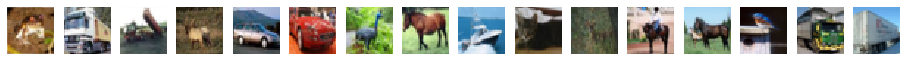

In [63]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype(np.float32) / 255
print(x_train.shape, x_train[9][0])
plot_multiple_images(x_train[:16])
x_train = x_train* 2. - 1. 
print(x_train.shape, x_train[9][0])
x_train = (x_train+1)/2
print(x_train.shape, x_train[9][0])
plot_multiple_images(x_train[:16])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 32, 32, 3)         1037827   
_________________________________________________________________
sequential_16 (Sequential)   (None, 1)                 217985    
Total params: 1,255,812
Trainable params: 1,255,428
Non-trainable params: 384
_________________________________________________________________


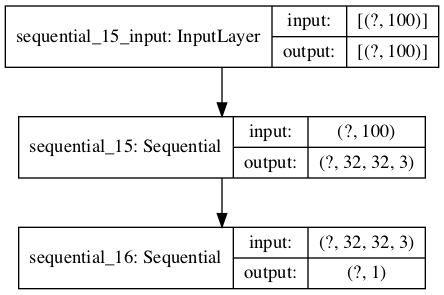

In [54]:
gan = GAN(x_train)
plot_model(gan.gan, show_shapes=True)

In [55]:
gan.fit(5)

<PrefetchDataset shapes: (32, 32, 32, 3), types: tf.float32>
Epoch 1/5


KeyboardInterrupt: 

<PrefetchDataset shapes: (32, 28, 28, 1), types: tf.float32>


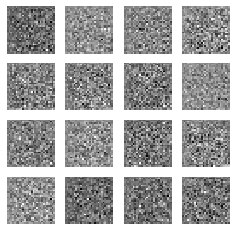

Epoch 1/5


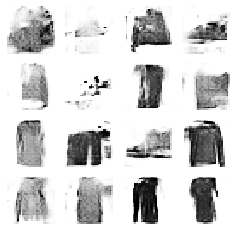

Epoch 2/5


KeyboardInterrupt: 

In [18]:
train_gan(gan, x_train_dcgan, 5)

In [26]:
gan.


In [ ]:
: